In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import assist_function

# load model

In [2]:
model = tf.keras.models.load_model('trained_models\DCNN_model.hdf5')

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1000)              25636712  
                                                                 
 dense_1 (Dense)             (None, 256)               256256    
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 26,090,601
Trainable params: 453,889
Non-t

# load data

In [4]:
current_model = [224, 224, 3]

X_test, y_test = assist_function.load_and_resize(
    "data/input_data/labelled_pair_test.txt", current_model)

y_test[y_test < 100] = 0
y_test[y_test >= 100] = 1
y_test_GVI = np.mean(y_test, axis=(1,2))

print(X_test.shape, y_test.shape, y_test_GVI.shape)

(80, 224, 224, 3) (80, 224, 224) (80,)


In [5]:
test_metadata = assist_function.retrieve_metadata('data/input_data/labelled_pair_test.txt')
test_metadata.head(3)

,lat,lng,heading
0,1.464214838923537,103.7680466183046,120
1,1.45906910621281,103.7668877466677,180
2,1.463961299646011,103.7717313271459,180


# Inference

In [6]:
import time
st =  time.time()

pred_ts = model.predict(X_test, batch_size=8)
pred_ts.shape

et =  time.time()
elapsed_time = et - st
print('training time = ', elapsed_time,'seconds')

10/10 [==============================] - 6s 496ms/step
training time =  6.193286895751953 seconds


In [7]:
# compute difference between prediction and true GVI
diff = np.zeros([len(X_test), 1])
for i in range(len(X_test)):
    diff[i] = y_test_GVI[i]-pred_ts[i]

# evaluate accuracy of model
print("Average Absolute GVI error is: %f" % np.mean(np.abs(diff)))
percentile_result = np.percentile(diff, [5, 95])
print("5-95 percentile of Absolute GVI error is (%f, %f)" %
      (percentile_result[0], percentile_result[1]))
print("Correlation of predicted and true GVI is: %f" %
      np.corrcoef(pred_ts.T, y_test_GVI.T)[0, 1])

Average Absolute GVI error is: 0.045872
5-95 percentile of Absolute GVI error is (-0.067116, 0.087973)
Correlation of predicted and true GVI is: 0.969098


In [25]:
DCNN_prediction = pd.concat([test_metadata, pd.Series(pred_ts.flatten()), pd.Series(y_test_GVI)], 
                            axis=1)
DCNN_prediction = DCNN_prediction.rename(columns={0: 'pred', 1: 'gt'})
DCNN_prediction['diff'] = (DCNN_prediction['gt'] - DCNN_prediction['pred']).abs()
DCNN_prediction

,lat,lng,heading,pred,gt,diff
0,1.464214838923537,103.7680466183046,120,0.086347,0.141582,0.055235
1,1.45906910621281,103.7668877466677,180,0.018569,0.000000,0.018569
2,1.463961299646011,103.7717313271459,180,0.154015,0.197325,0.043310
3,1.467388080645603,103.7654123835077,0,0.025451,0.040079,0.014628
4,1.46385196757463,103.7714928793899,180,0.052868,0.000000,0.052868
...,...,...,...,...,...,...
75,1.461623873936034,103.7626822794463,180,0.143442,0.091996,0.051446
76,1.471528068901578,103.7667682176015,120,0.186192,0.234116,0.047924
77,1.4586617,103.7687351,0,0.006767,0.000000,0.006767
78,1.46526614898588,103.7697100603857,0,0.480197,0.431780,0.048417


In [26]:
DCNN_prediction['diff_with_sign'] = DCNN_prediction['pred'] - DCNN_prediction['gt']

Text(0.5, 1.0, 'Investigating bias (DCNN)')

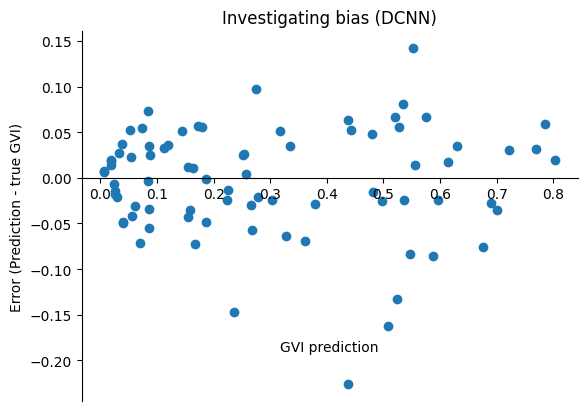

In [27]:
# Create a figure and axes
fig, ax = plt.subplots()

# Plot the data
ax.scatter(DCNN_prediction['pred'], DCNN_prediction['diff_with_sign'])

# Move the y-axis to x=0
ax.spines['bottom'].set_position(('data', 0))
# Remove the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel("GVI prediction", labelpad=100)
ax.set_ylabel("Error (Prediction - true GVI)")
ax.set_title("Investigating bias (DCNN)")

In [10]:
DCNN_prediction.loc[DCNN_prediction['pred'] < DCNN_prediction['gt'], 'estimation'] = 'underestimation'
DCNN_prediction.loc[DCNN_prediction['pred'] == DCNN_prediction['gt'], 'estimation'] = 'accurate estimation'
DCNN_prediction.loc[DCNN_prediction['pred'] > DCNN_prediction['gt'], 'estimation'] = 'overestimation'

In [12]:
DCNN_prediction.estimation.value_counts()

overestimation     41
underestimation    39
Name: estimation, dtype: int64

In [22]:
grouped_df = pd.DataFrame(DCNN_prediction.groupby([bins, 'estimation']).size()).reset_index().rename(columns={0: 'count'})
grouped_df.pred = grouped_df.pred.astype(str)
grouped_df

,pred,estimation,count
0,"(0.00597, 0.206]",overestimation,20
1,"(0.00597, 0.206]",underestimation,17
2,"(0.206, 0.405]",overestimation,6
3,"(0.206, 0.405]",underestimation,10
4,"(0.405, 0.604]",overestimation,9
5,"(0.405, 0.604]",underestimation,9
6,"(0.604, 0.803]",overestimation,6
7,"(0.604, 0.803]",underestimation,3


Text(0.5, 1.0, 'Error analysis of GVI prediction predictions by bins (DCNN)')

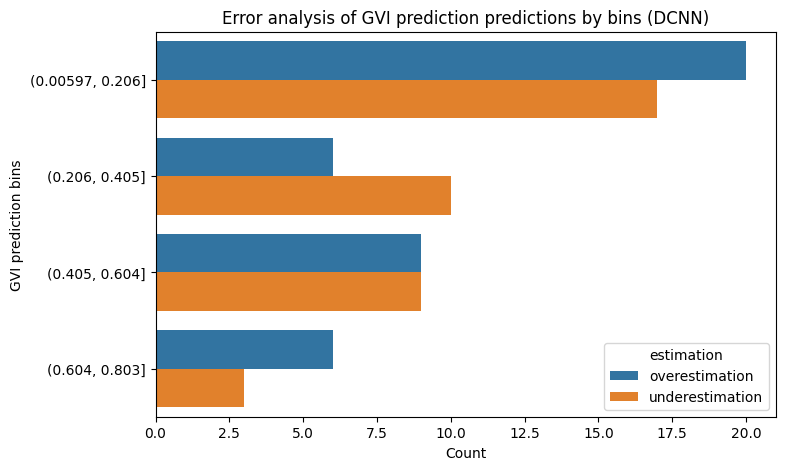

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Assuming you have the grouped_df DataFrame with two levels of index
# grouped_df = ...

# Plot the bar chart
fig, ax = plt.subplots(figsize=(8, 5))
plt.show = sns.barplot( data=grouped_df, hue='estimation', x='count', y='pred', orient='h', dodge=True, ax=ax)

#ax.set_yticklabels(grouped_df[['pred']].astype(str))
ax.set_xlabel('Count')
ax.set_ylabel('GVI prediction bins')
ax.set_title('Error analysis of GVI prediction predictions by bins (DCNN)')


In [21]:
import pandas as pd


# Create bins using pd.cut
bins = pd.cut(DCNN_prediction['pred'], bins=4)

# Group by bins and count
grouped_df = DCNN_prediction.groupby([bins, 'estimation']).size()

grouped_df

pred              estimation     
(0.00597, 0.206]  overestimation     20
                  underestimation    17
(0.206, 0.405]    overestimation      6
                  underestimation    10
(0.405, 0.604]    overestimation      9
                  underestimation     9
(0.604, 0.803]    overestimation      6
                  underestimation     3
dtype: int64

In [9]:
#DCNN_prediction.to_csv("data/output_data/DCNN_test_evaluation.csv")